In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from fullfrlm import flow_refueling_location_model
from generate_network import generate_network
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from create_input_data_abm import create_input_data_abm
from visualize_placement import visualize_placement
from get_abm_data import get_vessel_data_batch, get_cs_data_batch
import pickle
from determine_additional_nodes import determine_additional_nodes
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
# pick seeds
import numpy as np
pick_from = np.linspace(0, 1000000, 1000001)
seeds = np.random.choice(a=pick_from, size=100, replace=False)
seeds = list(seeds)
seeds = [round(i) for i in seeds]

In [3]:
seeds

[943494,
 747817,
 211231,
 913826,
 157,
 48396,
 226292,
 444196,
 15235,
 709996,
 493322,
 670518,
 838529,
 742965,
 593642,
 159428,
 668170,
 596615,
 850162,
 485122,
 900800,
 180827,
 159563,
 328698,
 74681,
 289432,
 284741,
 106083,
 186920,
 576313,
 554985,
 100416,
 996524,
 269904,
 293145,
 854661,
 318669,
 598919,
 454911,
 855086,
 111278,
 262426,
 741924,
 873830,
 75839,
 418128,
 251488,
 575121,
 517018,
 106099,
 220974,
 49242,
 991079,
 522317,
 129131,
 166691,
 194982,
 665137,
 903620,
 941114,
 299463,
 230940,
 37162,
 80155,
 458045,
 745726,
 972860,
 791946,
 265923,
 251978,
 865671,
 219439,
 481474,
 314216,
 332444,
 982404,
 604260,
 771360,
 575463,
 675663,
 472370,
 330697,
 67628,
 812510,
 882277,
 918652,
 635611,
 396538,
 189907,
 811660,
 524835,
 457074,
 456951,
 498873,
 570871,
 343070,
 874264,
 663851,
 144913,
 410208]

In [4]:
seeds = [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030]

There were 47 nodes added, the longest remaining link is now: 24367.051832467885
9 intersections were added
Optimal
CPU times: total: 16.2 s
Wall time: 16.8 s


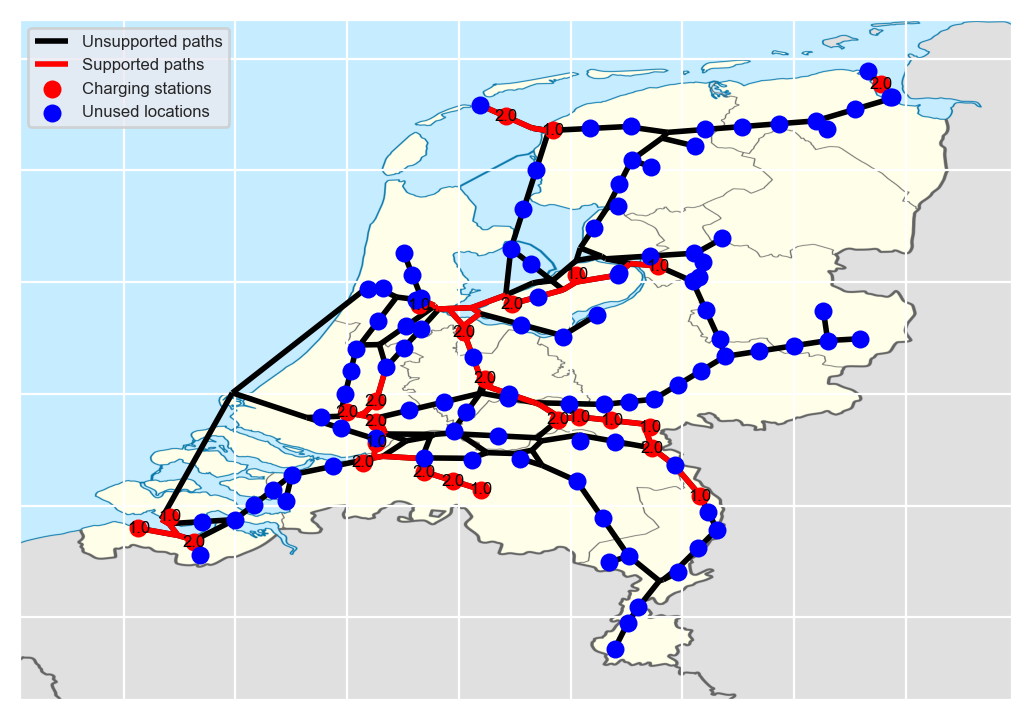

In [7]:
%%time
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, \
    non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(1, seeds[0], 50000, 15000, 175, 40, 600, 2, 24, False, True, True, True)

In [ ]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
facilities = [i for i in optimal_facilities.keys() if optimal_facilities[i] > 0]

extra_nodes_used = list(set(facilities)-set(list(df_h.harbour_node)))

In [ ]:
print(total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported)

# Complete batch run first before continuing
Run file batchrun.py in ABM/ownwork

## Rerun using feedback from ABM

In [ ]:
vessel_data_abm = get_vessel_data_batch()

In [ ]:
station_data_abm = get_cs_data_batch()

In [ ]:
station_data_abm

In [ ]:
top5_least_used = list(station_data_abm.sort_values(by='occupation').head(5).index)

In [ ]:
top5_least_used

In [ ]:
%%time
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, \
non_zero_flows, routes_supported, paths, G, df_abm, df_random_out = flow_refueling_location_model(load, 70000, 40, 1000, 2, df_random, False, False, True, top5_least_used)

In [ ]:
facilities = [i for i in optimal_facilities.keys() if optimal_facilities[i] > 0]
extra_nodes_used = list(set(facilities) - set(list(df_h.harbour_node)))
extra_nodes_used

In [ ]:

print(total_flow, fraction_captured_total, serveable_fraction, served_fraction, routes_supported)

## Now simulate again

## Stepwise run of all components of frlm

### Load necessary data

In [ ]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [ ]:
df_ivs

## Generate random df

In [ ]:
%%time
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)

In [ ]:
df_random1


## Compute path flows

In [ ]:
%%time
flows = flow_computation(df_random1)

In [ ]:
sum(flows.values())

## Generate network

In [ ]:
%%time
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))
G, paths, inserted_nodes = generate_network(G, paths, 70000)

In [ ]:
inserted_nodes += determine_additional_nodes(G, df_h, 70000)

In [ ]:
inserted_nodes

In [ ]:
%%time
# range r in meters
df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(70000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted_nodes)

## Run second stage FRLM

In [ ]:
%%time
optimal_facilities, optimal_flows, non_zero_flows, supported_flow, routes_supported = second_stage_frlm(70000, 15000, 175, 40, 2500, 2, df_g, df_b, df_eq_fq)

In [ ]:
optimal_facilities

In [ ]:
sum(optimal_facilities.values())

In [ ]:
sum(optimal_flows.values())

In [ ]:
supported_flow

## Create input data ABM

In [ ]:
%%time
df_abm = create_input_data_abm(G, paths, non_zero_flows, optimal_facilities)

In [ ]:
df_abm

## Visualize placement

In [ ]:
visualize_placement(G,flows, optimal_facilities, non_zero_flows, df_h, paths, True)